# Tomography

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

## 0) Loading the data

To solve the task, we first need to load the list of angles and the measured sensor data (and define $M$ so we have all required information to solve the problem).

In [2]:
Np = 77
alphas = np.load(f"data/alphas_{Np}.npy")
y = np.load(f"data/y_{Np}.npy")

print(f"Loaded a dataset with sensor size {Np} and {len(alphas)} measurements.\n")

M = 10

print(f"M := {M}")
print(f"N = {Np} * {len(alphas)} = {len(y)}")
print(f"D = M^2 = {M ** 2}")

Loaded a dataset with sensor size 77 and 90 measurements.

M := 10
N = 77 * 90 = 9810
D = M^2 = 100


## 1) Constructing the matrix X

Now we can start constructing the $X$ matrix, as described in the task. We need to use the `scipy.sparse` tools to do so, since the matrix will be large.

In [3]:
def construct_X(M, alphas, Np = None) -> scipy.sparse.coo_matrix:
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
        
    N = Np * len(alphas)
    D = M ** 2
    
    # now we calculate the indexes and the data
    # this is fine to do since the matrix is sparse
    data = []
    i_indexes = []
    j_indexes = []
    
    # for each angle, calculate the contributions of the rows of the image to the sensor
    c_point = M / 2
    c_sensor = Np / 2

    # we're projecting a point (vector) onto a vector
    for i, alpha in enumerate(alphas):
        v_alpha = np.cos(np.deg2rad(alpha)), np.sin(np.deg2rad(alpha))
        
        for row in range(M):
            offset_row = -(row - c_point)
            for column in range(M):
                offset_column = (column - c_point)
                
                # since we only need the length (index of the sensor), a dot product is sufficient            
                idx = np.dot((offset_column, offset_row), v_alpha) + c_sensor
                
                assert 0 <= idx < Np
        
                # distribute among the 2 affected sensors
                s1_pos = int(idx)
                s2_pos = int(idx + 1)
                
                assert s1_pos < idx < s2_pos
                
                s1_val = 1 - (idx - s1_pos)
                s2_val = 1 - (s2_pos - idx)
                
                assert s1_val > 0
                assert s2_val > 0
                assert abs(s1_val + s2_val - 1) < 0.01
                
                for (d, x, y) in [
                    (
                        s1_val,
                        column + row * M,
                        s1_pos + i * Np,
                    ),
                    (
                        s2_val,
                        column + row * M,
                        s2_pos + i * Np,
                    ),
                ]:
                    data.append(d)
                    i_indexes.append(y)
                    j_indexes.append(x)

    return scipy.sparse.coo_matrix((data, (i_indexes, j_indexes)), shape=(N, D), dtype=np.float32)

X = construct_X(10, [1]).toarray()

Now we can check the implementation with the provided `X_example.npy` matrix to see if the construction works:

Text(0.5, 1.0, 'Example X')

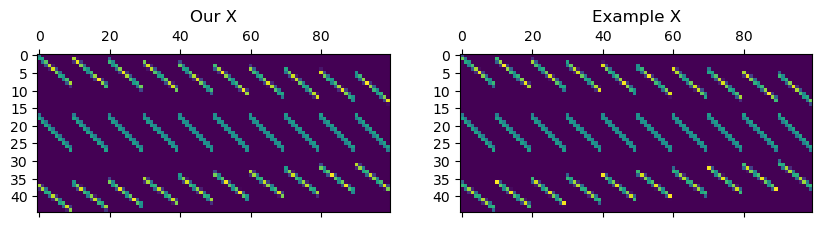

In [4]:
X = construct_X(10, [-33, 1, 42]).toarray()
X_example = np.load(f"data/X_example.npy")

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.matshow(X)
ax1.set_title('Our X')

ax2.matshow(X_example)
ax2.set_title('Example X')

TODO: it seems that the matrices are similar but not quite exact. If we have time, look into this.